# K-stability

Here we investigate whether the dimension k of adversarial subspaces for AE tend to be larger than those of "clean" (unmodified) examples in the case when AE occupy the \epsilon-stable region of the clean example.  Part of our motivation is to determine whether "k-stability" is a reasonable detector for AE having small perturbations.

For a precise definition of \epsilon-stable, please see our writeup.

In [5]:
%matplotlib inline

import os
import time
import numpy as np
import pylab as plt
import pandas as pd
plt.rcParams['figure.figsize'] = (16,9)
from matplotlib import colors


In [3]:
def estimate_epsilon_stability(df, e_id, dataset, fudge_factor=2.0, large_constant=40.0):
    # grab "gaussian" directions originating from clean example
    subset = (df['Example#'] == e_id) & (df['direction_type'] == 'gaussian') & (df['Dataset'] == dataset)

    # Generate an estimate for the \epsilon stable region
    epsilon_est = np.min(df[subset]['boundary_distance'])
    return min(epsilon_est / fudge_factor, large_constant)
    
    

def estimate_k_stability(df, e_id, dataset, epsilon_ref):
    # grab subset of data corresponding to this example/point type
    gaas_idx = (df['Example#'] == e_id) & (df['direction_type'] == 'gaas') & (df['Dataset'] == dataset)
    subset = df[gaas_idx]
    
    if len(subset) == 0:
        return None
    
    # Here we search brute force for the largest value of k for which most of the
    # boundary distances are less than or equal to epsilon_ref.
    # i.e. we seek the largest subspace such that by moving no more than epsilon_ref
    # we are able to produce mostly AE with each basis vector.
    k_all = pd.unique(subset['k'])
    k_est = 0
    
    for idx, k in enumerate(k_all):
        tmp = subset[subset['k'] == k]
        freq = np.sum(tmp['boundary_distance'] <= epsilon_ref)
        #print(epsilon_ref, freq, k) # TEMP
        if freq < (k/2.0):
            break # too many directions were ineffective
        else:
            k_est = k
            
    #print(subset) # TEMP
    return k_est # the last value of k for which we were mostly unchanged in class label

In [4]:
df = pd.read_pickle(os.path.expanduser("~/cifar10_stats_df_CH.pkl"))

print(df.dtypes.index)

all_datasets = pd.unique(df['Dataset'])
all_examples = pd.unique(df['Example#'])


print('frame has %d datasets and %d unique examples' % (len(all_datasets), len(all_examples)))
print(all_datasets)
df.head()

Index(['Approx_conf', 'Dataset', 'Example#', 'boundary_distance', 'delta_l2',
       'delta_loss', 'direction_id', 'direction_type', 'ell2_grad', 'k', 'y',
       'y_hat'],
      dtype='object')
frame has 21 datasets and 168 unique examples
['cifar10' 'FGM-10.00' 'FGM-2.50' 'FGM-5.00' 'I-FGM-1.50' 'I-FGM-10.00'
 'I-FGM-2.00' 'I-FGM-2.50' 'I-FGM-5.00' 'FGM-0.30' 'FGM-0.50' 'FGM-0.75'
 'FGM-1.00' 'FGM-1.50' 'FGM-2.00' 'I-FGM-0.30' 'I-FGM-0.50' 'I-FGM-0.75'
 'I-FGM-1.00' 'I-FGM-0.20' 'FGM-0.20']


,Approx_conf,Dataset,Example#,boundary_distance,delta_l2,delta_loss,direction_id,direction_type,ell2_grad,k,y,y_hat
0,2.384989,cifar10,0,2.248105,NaN,1.184469,NaN,gradient,0.484421,NaN,3,1.0
1,2.384989,cifar10,0,inf,NaN,NaN,NaN,neg-gradient,0.484421,NaN,3,NaN
2,2.384989,cifar10,0,10.786918,NaN,1.111750,NaN,gaussian,0.484421,NaN,3,6.0
3,2.384989,cifar10,0,16.394444,NaN,1.034890,NaN,gaussian,0.484421,NaN,3,6.0
4,2.384989,cifar10,0,16.801848,NaN,1.163014,NaN,gaussian,0.484421,NaN,3,6.0


In [12]:
#=================================================================================
# Stability estimates for each clean example.
# More sophisticated methods are of course possible (and probably desirable)
#=================================================================================

epsilon_clean = np.zeros((len(all_examples),))
k_max_clean = np.zeros((len(all_examples),))

subset = df[df['Dataset'] == 'cifar10']  # speeds up calculations later

tic = time.time()
for idx, e_id in enumerate(all_examples):
    epsilon_clean[idx] = estimate_epsilon_stability(subset, e_id, 'cifar10')
    k_max_clean[idx] = estimate_k_stability(subset, e_id, 'cifar10', epsilon_clean[idx])
    
print('Took %0.2f seconds to compute stability metrics for clean' % (time.time() - tic))

Took 4.38 seconds to compute stability metrics for clean


there are 168 clean examples total


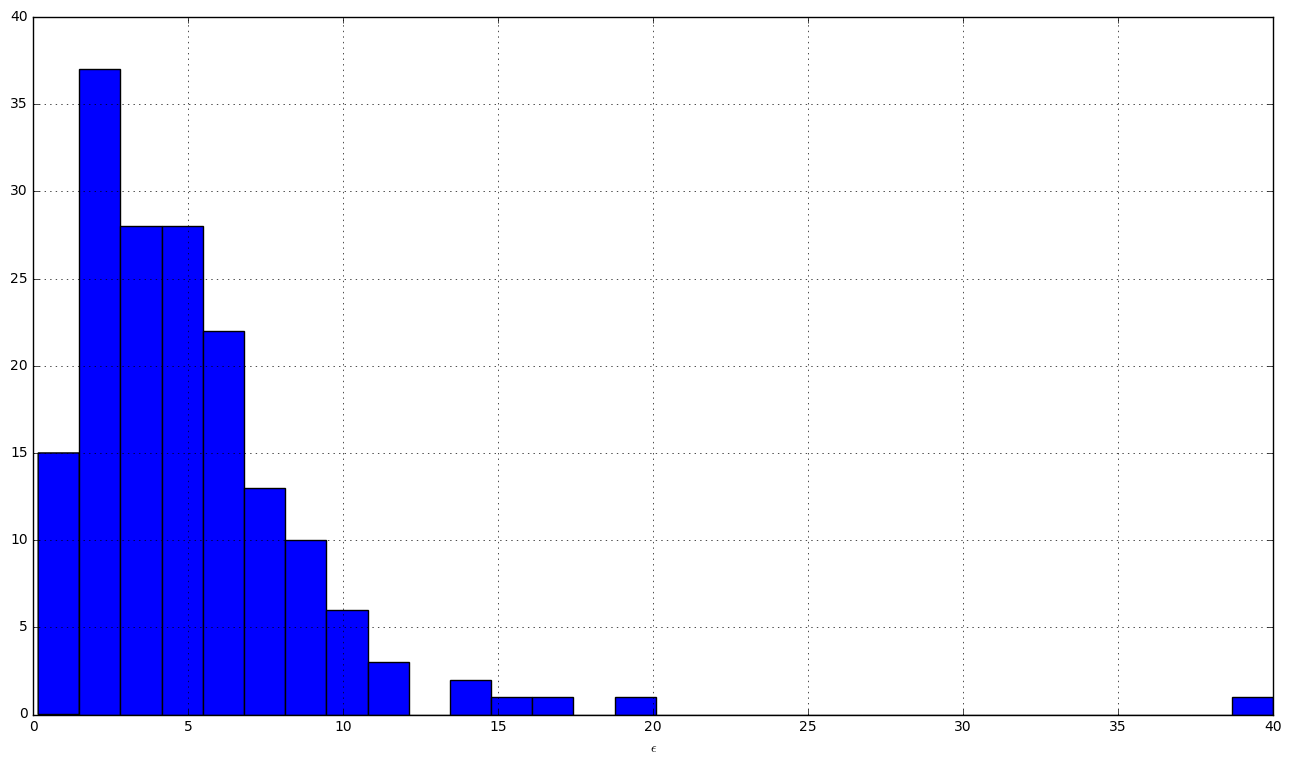

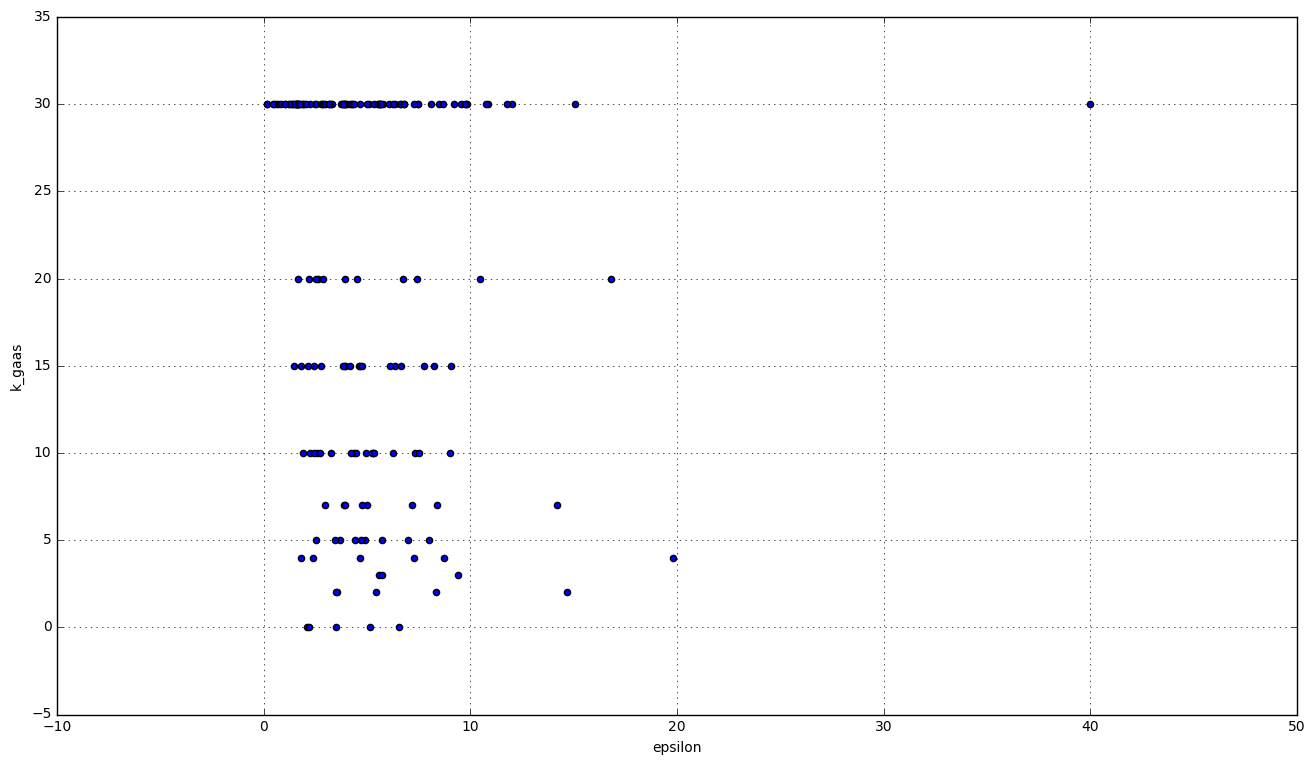

In [14]:
#=================================================================================
# Some statistics related to \epsilon-stability
#=================================================================================

print('there are %d clean examples total' % epsilon_clean.size)

plt.figure()
plt.hist(epsilon_clean, 30)
plt.xlabel('$\epsilon$')
plt.grid('on')


plt.figure()
plt.scatter(epsilon_clean, k_max_clean)
plt.xlabel('epsilon')
plt.ylabel('k_gaas')
plt.grid('on')

plt.show()


In [20]:
#=================================================================================
# Stability estimates for AE
#=================================================================================

epsilon_ae = {}
k_max_ae = {}
tic = time.time()

for data_set in all_datasets:
    if data_set == 'cifar10':
        continue # we already did this above
        
    this_data_set = df[df['Dataset'] == data_set]
        
    epsilon_i = np.nan * np.zeros((len(all_examples),))
    k_max_i = np.nan * np.zeros((len(all_examples),))

    for idx, e_id in enumerate(all_examples):
        subset = this_data_set[this_data_set['Example#'] == e_id]
        
        if len(subset) == 0:
            continue
        
        # check to see if this AE is in the stability region of its clean origin.
        # if not, we skip it.
        ae_dist = np.median(subset['delta_l2']) # these values should all be same; median just picks one
        if ae_dist > epsilon_clean[idx]:
            continue
        
        epsilon_i[idx] = estimate_epsilon_stability(subset, e_id, data_set)
        k_max_i[idx] = estimate_k_stability(subset, e_id, data_set, epsilon_clean[idx])  # note: reference stability is for *clean* example!
  
    print('Finished with %s; net runtime: %0.2f sec' % (data_set, time.time()-tic))
    epsilon_ae[data_set] = epsilon_i
    k_max_ae[data_set] = k_max_i

Finished with FGM-10.00; net runtime: 0.28 sec
Finished with FGM-2.50; net runtime: 1.44 sec
Finished with FGM-5.00; net runtime: 2.25 sec
Finished with I-FGM-1.50; net runtime: 3.48 sec
Finished with I-FGM-10.00; net runtime: 3.78 sec
Finished with I-FGM-2.00; net runtime: 4.98 sec
Finished with I-FGM-2.50; net runtime: 6.15 sec
Finished with I-FGM-5.00; net runtime: 7.04 sec
Finished with FGM-0.30; net runtime: 7.54 sec
Finished with FGM-0.50; net runtime: 8.25 sec
Finished with FGM-0.75; net runtime: 9.14 sec
Finished with FGM-1.00; net runtime: 10.21 sec
Finished with FGM-1.50; net runtime: 11.48 sec
Finished with FGM-2.00; net runtime: 12.61 sec
Finished with I-FGM-0.30; net runtime: 13.14 sec
Finished with I-FGM-0.50; net runtime: 13.90 sec
Finished with I-FGM-0.75; net runtime: 14.83 sec
Finished with I-FGM-1.00; net runtime: 15.93 sec
Finished with I-FGM-0.20; net runtime: 16.25 sec
Finished with FGM-0.20; net runtime: 16.56 sec
